In [13]:
import numpy as np
import pandas as pd
import os
import mne
import matplotlib.pyplot as plt

%matplotlib qt

# ARI

In [14]:
def deduplicate_responses(trial):
    """Remove duplicate 3 and 4 triggers (button presses), keep first occurrence."""
    clean_array = []
    seen = set()
    duplicates = []


    for row in trial:
        code = row[2]
        if code in (3, 4):
            if code in seen:
                duplicates.append(row)
                continue
            seen.add(code)
        clean_array.append(row)

    return np.array(clean_array), np.array(duplicates) if duplicates else None

In [15]:
def classify_trial(trial):
    """Classify a trial as 'go', 'stop', or 'bad' based on event codes."""
    # Extract event codes
    codes = trial[:, 2].tolist()

    # Must start and end correctly
    if codes[0] != 1 or codes[-1] != 6:
        return 'bad'

    # Required onset
    if 2 not in codes:
        return 'bad'

    # Enforce order: 1 < 2 < 6
    i1 = codes.index(1)
    i2 = codes.index(2)
    i6 = len(codes) - 1
    if not (i1 < i2 < i6):
        return 'bad'

    has_stop = 5 in codes
    has_3 = 3 in codes
    has_4 = 4 in codes

    # Count occurrences
    n3 = codes.count(3)
    n4 = codes.count(4)
    n5 = codes.count(5)

    # ---------- GO TRIAL ----------
    # 1 - 2 - 3 & 4 (any order) - 6
    if not has_stop:
        if has_3 and has_4 and n3 == 1 and n4 == 1:
            return 'go'
        else:
            return 'bad'

    # ---------- STOP TRIAL ----------
    # 1 - 2 - 5 - 6 (no responses)
    if has_stop:
        if n5 == 1 and not has_3 and not has_4:
            return 'stop'
        else:
            return 'bad'


In [60]:
eeg_path = "C:\\Users\\a1902989\\Box\\Katya\\# PD project\\pilot\\eeg"
eeg_file_name = "test_AM_07_ARI.vhdr"
raw = mne.io.read_raw_brainvision(os.path.join(eeg_path, eeg_file_name), preload=True)
raw.info

Extracting parameters from C:\Users\a1902989\Box\Katya\# PD project\pilot\eeg\test_AM_07_ARI.vhdr...
Setting channel info structure...
Reading 0 ... 794029  =      0.000 ...  1588.058 secs...


C:\Users\a1902989\AppData\Local\Temp\ipykernel_33112\1969921993.py:3: RuntimeWarning: No coordinate information found for channels ['Photodiode', 'Acc X', 'Acc Y', 'Acc Z', 'EMG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(os.path.join(eeg_path, eeg_file_name), preload=True)
C:\Users\a1902989\AppData\Local\Temp\ipykernel_33112\1969921993.py:3: RuntimeWarning: Not setting positions of 5 misc channels found in montage:
['Photodiode', 'Acc X', 'Acc Y', 'Acc Z', 'EMG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(os.path.join(eeg_path, eeg_file_name), preload=True)


<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 64 EEG, 5 misc
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 131.0 Hz
 meas_date: 2026-01-14 15:03:51 UTC
 nchan: 69
 projs: []
 sfreq: 500.0 Hz
>

**Prep for epoching: Read events and annotate bad trials**

In [61]:
# 1 = trial start (empty bars appear)
# 2 = trial onset (bar starts filling)
# 3 = left response
# 4 = right response
# 5 = stop signal presentation
# 6 = trial end (prior to ITI)

# 19 = go only practice
# 20 = go/stop practice
# 21:n trials+20 = training blocks

events_dict = mne.events_from_annotations(raw)[1]
events = mne.events_from_annotations(raw)[0]
task_onset = np.where(events[:, 2] == 21)[0][0]   # index of the first block onset
events = events[task_onset:].copy() # drop practice trials
events_dict

Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S 19'), np.str_('Stimulus/S 20'), np.str_('Stimulus/S 21'), np.str_('Stimulus/S 22'), np.str_('Stimulus/S 23'), np.str_('Stimulus/S 24'), np.str_('Stimulus/S 25'), np.str_('Stimulus/S 26'), np.str_('Stimulus/S 27'), np.str_('Stimulus/S 28'), np.str_('Stimulus/S 29'), np.str_('Stimulus/S 30'), np.str_('Stimulus/S 31'), np.str_('Stimulus/S 32')]
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S 19'), np.str_('Stimulus/S 20'), np.str_('Stimulus/S 21'), np.str_('Stimulus/S 22'), np.str_('Stimulus/S 23'), np.str_('Stimulus/S 24'), np.str_('Stimulus/S 25'), np.str_('Stimulus/S 26'), np.str_('Stimulus/S 27'), np.str_('Stimulus/S 28'), 

{np.str_('Stimulus/S  1'): 1,
 np.str_('Stimulus/S  2'): 2,
 np.str_('Stimulus/S  3'): 3,
 np.str_('Stimulus/S  4'): 4,
 np.str_('Stimulus/S  5'): 5,
 np.str_('Stimulus/S  6'): 6,
 np.str_('Stimulus/S 19'): 19,
 np.str_('Stimulus/S 20'): 20,
 np.str_('Stimulus/S 21'): 21,
 np.str_('Stimulus/S 22'): 22,
 np.str_('Stimulus/S 23'): 23,
 np.str_('Stimulus/S 24'): 24,
 np.str_('Stimulus/S 25'): 25,
 np.str_('Stimulus/S 26'): 26,
 np.str_('Stimulus/S 27'): 27,
 np.str_('Stimulus/S 28'): 28,
 np.str_('Stimulus/S 29'): 29,
 np.str_('Stimulus/S 30'): 30,
 np.str_('Stimulus/S 31'): 31,
 np.str_('Stimulus/S 32'): 32}

In [62]:
starts = np.where(events[:, 2] == 1)[0]
ends   = np.where(events[:, 2] == 6)[0]

assert len(starts) == len(ends), "Unmatched trial start/end triggers"

trial_events = []

for s, e in zip(starts, ends):
    trial_events.append(events[s:e+1])

In [63]:
# Deduplicate key responses and classify trials
clean_trials = [deduplicate_responses(t)[0] for t in trial_events]
duplicates = [deduplicate_responses(t)[1] for t in trial_events if deduplicate_responses(t)[1] is not None]
events_clean = events.copy()

for dup in duplicates:
    events_clean = events_clean[~np.all(events_clean == dup, axis=1)]

labels = [classify_trial(t) for t in clean_trials]

good_go   = [t for t, l in zip(clean_trials, labels) if l == 'go']
good_stop = [t for t, l in zip(clean_trials, labels) if l == 'stop']
bad       = [t for t, l in zip(clean_trials, labels) if l == 'bad']

print(f"Go trials   : {len(good_go)}")
print(f"Stop trials : {len(good_stop)}")
print(f"Bad trials  : {len(bad)}")

Go trials   : 242
Stop trials : 45
Bad trials  : 97


In [64]:
# Setting up annotations for bad trials: based on behavioral performance
sfreq = raw.info['sfreq']

onsets = []
durations = []
descriptions = []

for trial in bad:
    start_samp = trial[0, 0]
    end_samp   = trial[-1, 0]

    onsets.append(start_samp / sfreq)
    durations.append((end_samp - start_samp) / sfreq)
    descriptions.append('BAD')
bad_annots = mne.Annotations(onsets, durations, descriptions)

# Remove existing annotations (events are stored as np.array) and set new ones
raw.set_annotations(None)
raw.set_annotations(bad_annots)
# raw.plot(events=events_clean)


<RawBrainVision | test_AM_07_ARI.eeg, 69 x 794030 (1588.1 s), ~418.1 MiB, data loaded>

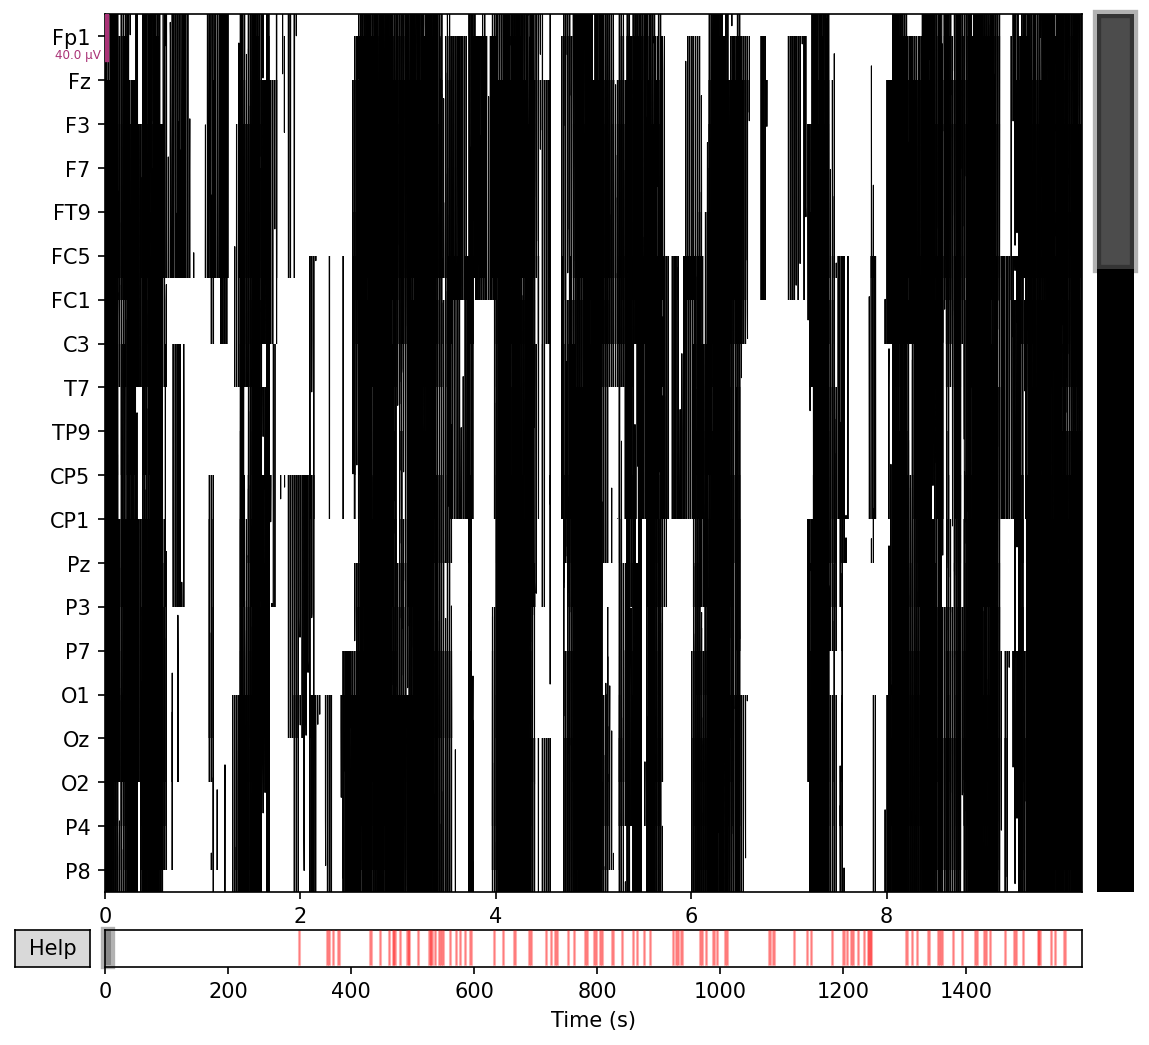

In [65]:
raw.plot(events=events_clean)

**Define timing and events for epoching**

In [66]:
# Timing between start of the trial and onset of bars AND start to end of trial
sfreq = raw.info['sfreq']

starts = events[events[:, 2] == 1][:, 0]
onsets = events[events[:, 2] == 2][:, 0]
ends = events[events[:, 2] == 6][:, 0]

n_trials = len(starts)

timing = pd.DataFrame({
    'start_to_onset': (onsets - starts) / sfreq,
    'start_to_end': (ends - starts) / sfreq
})
timing.describe()

,start_to_onset,start_to_end
count,384.000000,384.000000
mean,0.743333,2.017812
std,0.146991,0.147278
min,0.496000,1.772000
25%,0.617500,1.890000
50%,0.737000,2.014000
75%,0.868000,2.146000
max,1.000000,2.278000


In [67]:
# Timing of inter-trial intervals (ITI)
intervals = np.append(np.where((starts[1:] - ends[:-1]) / sfreq <= 2,
                                (starts[1:] - ends[:-1]) / sfreq,
                                np.nan),
                      np.nan)
pd.Series(intervals).describe()


count    372.000000
mean       1.013683
std        0.001621
min        0.990000
25%        1.014000
50%        1.014000
75%        1.014000
max        1.018000
dtype: float64

In [68]:
# Timing from stop signal to end of trial
rows = []

for trial in trial_events:
    codes = trial[:, 2]
    if 5 in codes:
        samp_1 = trial[codes == 1][0, 0]
        samp_2 = trial[codes == 2][0, 0]
        samp_5 = trial[codes == 5][0, 0]
        samp_6 = trial[codes == 6][0, 0]

        rows.append({
            'start_to_onset': (samp_2 - samp_1) / sfreq,
            'onset_to_stop': (samp_5 - samp_2) / sfreq,
            'stop_to_end': (samp_6 - samp_5) / sfreq,
        })

stop_timing = pd.DataFrame(rows)
stop_timing.describe()

,start_to_onset,onset_to_stop,stop_to_end
count,96.000000,96.000000,96.000000
mean,0.737000,0.620542,0.653750
std,0.153444,0.024080,0.023935
min,0.508000,0.556000,0.592000
25%,0.605500,0.604000,0.645500
50%,0.723000,0.626000,0.646000
75%,0.859000,0.630000,0.672000
max,1.000000,0.680000,0.722000


Minimum timing for epochs:
- 1 sec prior to STOP signal:
    - start to bar onset: 0.51 s
    - bar onset to stop: 0.48 s
- 1.6 sec from stop signal to the next trial:
    - stop to end: 0.59 s
    - iti (end to start of the next trial): 1.00 s

**Conclusion:
Epoch around STOP signal: [-0.9 1.5]**

Not setting metadata
96 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 96 events and 1201 original time points ...
51 bad epochs dropped
You seem to have overlapping epochs. Some event lines may be duplicated in the plot.


C:\Users\a1902989\AppData\Local\Temp\ipykernel_33112\1831232568.py:13: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  epochs.plot(events=events_clean)


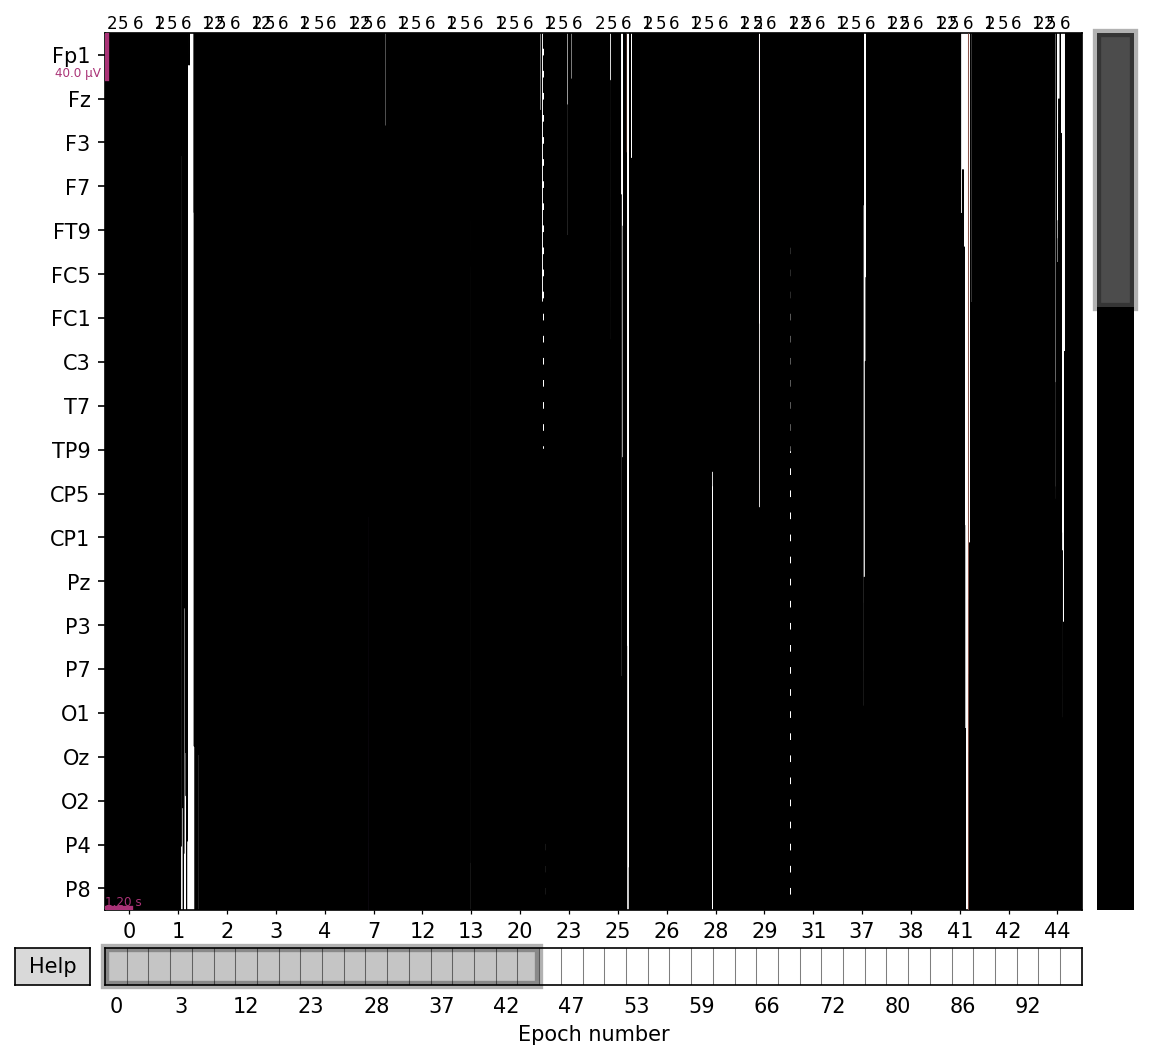

In [ ]:
# EPOCHING
events_stop = events_clean[events_clean[:, 2] == 5]

event_id = {'Stimulus/S  5': 5}
epo_tmin, epo_tmax = -0.9, 1.5

epochs = mne.Epochs(
    raw,
    events_stop,
    event_id=event_id,
    tmin=epo_tmin,
    tmax=epo_tmax,
    baseline=(epo_tmin, 0),
    reject_by_annotation=True,
    preload=True,
)
epochs.plot(events=events_clean) # NOTE: duplication of 2 trigger in some epochs on the plot (the data is fine)



In [98]:
epo_save_path = "D:\\BonoKat\\research project\\# PD project\\data_analysis\\ARI\\epochs"
np.save(os.path.join(epo_save_path, f'{eeg_file_name[:-5]}_clean_events.npy'), events_clean)
epochs.save(os.path.join(epo_save_path, f'{eeg_file_name[:-5]}_stop_epochs.fif'), overwrite=True)

Overwriting existing file.
Overwriting existing file.
Overwriting existing file.


C:\Users\a1902989\AppData\Local\Temp\ipykernel_33112\1841465711.py:3: RuntimeWarning: This filename (D:\BonoKat\research project\# PD project\data_analysis\ARI\epochs\test_AM_07_ARI_stop_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(os.path.join(epo_save_path, f'{eeg_file_name[:-5]}_stop_epochs.fif'), overwrite=True)


[WindowsPath('D:/BonoKat/research project/# PD project/data_analysis/ARI/epochs/test_AM_07_ARI_stop_epochs.fif')]